In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
import cv2 
import os

In [2]:
image_arr = []
mask_arr = []

for root,dirs,files in os.walk("KMCDATAExtracted"):
    path = root.split(os.path.sep)[-1]
    if (path == "img"):
        images = os.listdir(root)
        for i,image_name in enumerate(images):
            if image_name.endswith(".png"):
                image_arr.append(root + "\\" + image_name)
                
                
    elif (path == "mask"):
        images = os.listdir(root)
        for i,image_name in enumerate(images):
            if image_name.endswith(".png"):
                mask_arr.append(root + "\\" + image_name)

In [3]:
print(len(image_arr))
print(len(mask_arr))

6600
6600


# Dataset

In [71]:
image_dataset = []
mask_dataset = []

            
for i, image in enumerate(image_arr):
  #  mask = mask_dataset[i]
    mask_org = cv2.imread(mask_arr[i])
    image = cv2.imread(image_arr[i])
    mask = cv2.cvtColor(mask_org, cv2.COLOR_BGR2HSV)
    lower = np.array([50, 50, 50], dtype="uint8")
    upper = np.array([255, 255, 255], dtype="uint8")
    mask = cv2.inRange(mask, lower, upper)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#    print(len(cnts))
    
    for k,j in enumerate(cnts):
        M = cv2.moments(j)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
#             print(cx,cy,cy-152,cy+72,cx-142,cx+82)
            y=cy-152
            x=cx-142
            remainingy=0
            remainingx=0
            if y <0:
                remainingy=-y
                y=0
                
            if x <0:
                remainingx=-x
                x=0
            
            crop_mask = mask_org[y:cy+72+remainingy, x:cx+82+remainingx]
            image = image[y:cy+72+remainingy, x:cx+82+remainingx]
            crop_mask[crop_mask>0] = 255
            
            label_img = image_arr[i].split("\\")
            label_mask = mask_arr[i].split("\\")
    
            path_img = "new_data" + "\\" + label_img[1] + "\\" + label_img[2] + "\\" + label_img[3]
            path_mask = "new_data" + "\\" + label_mask[1] + "\\" + label_mask[2] + "\\" + label_mask[3]
            
            if(crop_mask.shape != (224,224,3) or image.shape != (224,224,3)):
                print("MASK",i, crop_mask.shape,mask)
                #print("IMAGE",image.shape)
            else:
                
                crop_image = cv2.resize(image, (256, 256),interpolation = cv2.INTER_LINEAR)
                crop_mask = cv2.resize(crop_mask, (256, 256),interpolation = cv2.INTER_LINEAR)
                
                cv2.imwrite(path_img,crop_image)
                cv2.imwrite(path_mask,crop_mask)
                
                image_dataset.append(crop_image)
                mask_dataset.append(crop_mask)

print("DONE")

DONE


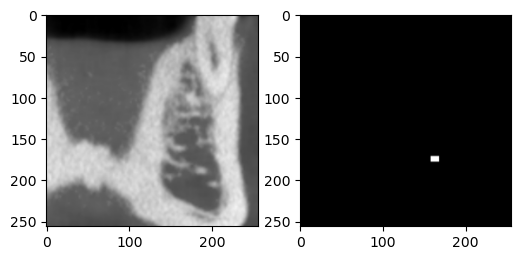

In [72]:
import matplotlib.image as mpimg 
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

# Labels


In [73]:
mask = "#FFFFFF"
mask = mask.lstrip("#")
mask = np.array(tuple(int(mask[i:i+2], 16) for i in (0, 2, 4)))

unlabeled = "#000000"
unlabeled = unlabeled.lstrip("#")
unlabeled = np.array(tuple(int(unlabeled[i:i+2], 16) for i in (0,2,4)))

In [74]:
print(unlabeled)
print(mask)

[0 0 0]
[255 255 255]


In [75]:
mask_dataset = np.array(mask_dataset, dtype = object)
image_dataset = np.array(image_dataset, dtype = object)

In [76]:
print(mask_dataset.shape)
print(image_dataset.shape)

(1923, 256, 256, 3)
(1923, 256, 256, 3)


In [77]:
def convert_labels(label):
    label_new = np.zeros(label.shape,dtype=np.uint8)
    label_new [np.all(label == mask,axis=-1)] = 1
    label_new [np.all(label==unlabeled,axis=-1)] = 0
   
    label_new = label_new[:,:,0]
    
    return label_new    

labels = []
for i in range(0, mask_dataset.shape[0]):
    label = convert_labels(mask_dataset[i])
    labels.append(label)
    
labels = np.array(labels).astype(np.int32)
labels = np.expand_dims(labels, axis = 3)

In [78]:
no_classes = len(np.unique(labels))
print(no_classes)
# from tensorflow.keras.utils import to_categorical
# labels = to_categorical(labels, no_classes)

2


In [79]:
labels.shape

(1923, 256, 256, 1)

# Model

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(image_dataset, labels, test_size = 0.2, random_state = 0)

In [81]:
X_train = np.array(X_train).astype(np.int32)
X_test = np.array(X_test).astype(np.int32)
Y_train = np.array(Y_train).astype(np.int32)
Y_test = np.array(Y_test).astype(np.int32)

In [82]:
X_train.shape

(1538, 256, 256, 3)

In [83]:
X_test.shape

(385, 256, 256, 3)

In [84]:
Y_train.shape

(1538, 256, 256, 1)

In [85]:
Y_test.shape

(385, 256, 256, 1)

In [86]:
print(np.unique(labels))

[0 1]


In [87]:
from tensorflow.keras.models import Model
def unet_model (n_classes = 2, height = 256, width = 256, channels = 3):
    
    input = Input((height, width, channels))

    conv_1 = Conv2D(16,(3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(input)
    conv_1 = Dropout(0.2)(conv_1)
    conv_1 = Conv2D(16,(3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_1)
    pool_1 = MaxPool2D((2,2))(conv_1)
                  
    conv_2 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(pool_1)
    conv_2 = Dropout(0.2)(conv_2)
    conv_2 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_2)
    pool_2 = MaxPool2D((2,2))(conv_2)
                  
    conv_3 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(pool_2)
    conv_3 = Dropout(0.2)(conv_3)
    conv_3 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_3)
    pool_3 = MaxPool2D((2,2))(conv_3)
                  
    conv_4 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(pool_3)
    conv_4 = Dropout(0.2)(conv_4)
    conv_4 = Conv2D(128, (3,3), activation = "relu", kernel_initializer= "he_normal", padding = "same")(conv_4)
    pool_4 = MaxPool2D((2,2))(conv_4)              
    
    conv_5 = Conv2D(256, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_5)
     
    conv_6 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(conv_5)
    conv_6 = concatenate([conv_6, conv_4])
    conv_6 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_6)
                  
    conv_7 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(conv_6)
    conv_7 = concatenate([conv_7, conv_3])
    conv_7 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_7)
    conv_7 = Dropout(0.2)(conv_7)
    conv_7 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_7)
                  
    conv_8 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(conv_7)
    conv_8 = concatenate([conv_8, conv_2])
    conv_8 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_8)
    conv_8 = Dropout(0.2)(conv_8)
    conv_8 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_8)
                  
    conv_9 = Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(conv_8)
    conv_9 = concatenate([conv_9, conv_1], axis = 3)
    conv_9 = Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_9)
    conv_9 = Dropout(0.2)(conv_9)
    conv_9 = Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(conv_9)
                  
    output = Conv2D(1, (1,1), activation = "sigmoid")(conv_9)
                  
    model = Model(inputs = [input], outputs = [output])
                  
    return model

In [88]:
img_height = X_train.shape[1]
img_width = X_train.shape[2]
img_channels = X_train.shape[3]

def get_model ():
    return unet_model(n_classes= no_classes, height= img_height, width=img_width, channels=img_channels)

In [89]:
model = get_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

 conv2d_52 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_10[0][0]']         
                                )                                                                 
                                                                                                  
 dropout_25 (Dropout)           (None, 128, 128, 32  0           ['conv2d_52[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_53 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_25[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 256, 256, 16  2064       ['conv2d_53[0][0]']              
 nspose)  

In [90]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, Y_train, 
                    batch_size = 64,
                    callbacks=[early_stop],
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, Y_test), 
                    shuffle=False)

Epoch 1/5
25/25 [==============================] - 370s 15s/step - loss: 1.4989 - accuracy: 0.9803 - val_loss: 0.2258 - val_accuracy: 0.9931
Epoch 2/5
25/25 [==============================] - 372s 15s/step - loss: 0.2464 - accuracy: 0.9886 - val_loss: 0.0617 - val_accuracy: 0.9933
Epoch 3/5
25/25 [==============================] - 373s 15s/step - loss: 0.1438 - accuracy: 0.9870 - val_loss: 0.0734 - val_accuracy: 0.9933
Epoch 4/5
25/25 [==============================] - 372s 15s/step - loss: 0.1031 - accuracy: 0.9899 - val_loss: 0.1790 - val_accuracy: 0.9933
Epoch 5/5
25/25 [==============================] - 379s 15s/step - loss: 0.0736 - accuracy: 0.9911 - val_loss: 0.1849 - val_accuracy: 0.9933


In [91]:
Y_pred = model.predict(X_test)

13/13 [==============================] - 20s 1s/step


In [92]:
Y_test = Y_test.flatten()
Y_pred = Y_pred.flatten()
Y_pred = (Y_pred > 0.5).astype(int)

In [93]:

from sklearn.metrics import classification_report
report = classification_report(Y_test, Y_pred)

In [94]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00  25063333
           1       0.00      0.00      0.00    168027

    accuracy                           0.99  25231360
   macro avg       0.50      0.50      0.50  25231360
weighted avg       0.99      0.99      0.99  25231360



In [95]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
(tn, fp, fn, tp)

(25063280, 53, 168027, 0)

In [96]:
sensitivity = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print("Sensitivity : {}".format(sensitivity))
print("Specificity : {}".format(specificity))

Sensitivity : 0.0
Specificity : 99.99978853570673


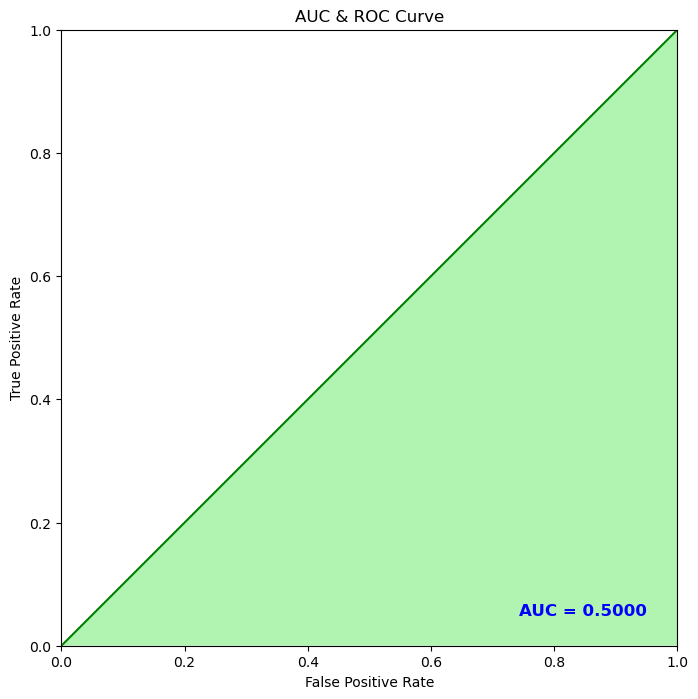

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(Y_test, Y_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(Y_test, Y_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()